# EDA
Explore data in `ecom_data.csv`

## Load

In [1]:
import pandas as pd
from datetime import date

# load raw data
df = pd.read_csv(
    'ecom_data.csv',
    dtype={
        'SalesOrder': str,
        'SKU': str,
        'Description': str,
        'UnitPrice': float,
        'CustomerID': int,
        'Channel': str,
        'State': str,
        'Sales': float,
        'Quantity': int
    },
    converters={
        'InvoiceDay': date.fromisoformat
    })

# drop duplicates
df.drop_duplicates(inplace=True)

# filter to positive sales transactions
df_sales = df[df.Sales > 0].reset_index(drop=True)

To recap the findings in `initial_eda_and_cleaning.ipynb`, I've determined the fields are:
- `SalesOrder`: Indicates order(s) a customer placed on a given `InvoiceDate`.
- `SKU`: Product ID.
- `Description`: Product name.
- `UnitPrice`: Price per unit.
- `CustomerID`: Customer ID.
- `Channel`: Sales channel for sale.
- `State`: State sale was made in/where customer purchased it.
- `Sales`: Total amount for sale.
- `Quantity`: Number of units sold.

Sales with negative `Sales` and `Quantity` values are refunds. We'll ignore those for now.

In [2]:
df_sales.head()

,SalesOrder,SKU,Description,UnitPrice,CustomerID,Channel,State,InvoiceDay,Sales,Quantity
0,580636,22474,SPACEBOY TV DINNER TRAY,1.95,16746,Mailing,IL,2011-12-05,31.20,16
1,581426,70006,LOVE HEART POCKET WARMER,0.79,17757,Organic Social,WA,2011-12-08,2.37,3
2,575063,22697,GREEN REGENCY TEACUP AND SAUCER,2.95,16764,Display,TX,2011-11-08,8.85,3
3,544065,20726,LUNCH BAG WOODLAND,1.65,14346,Organic Social,TX,2011-02-15,13.20,8
4,568896,85049E,SCANDINAVIAN REDS RIBBONS,1.25,16361,Store,NY,2011-09-29,52.50,42


## EDA
### Total Sales

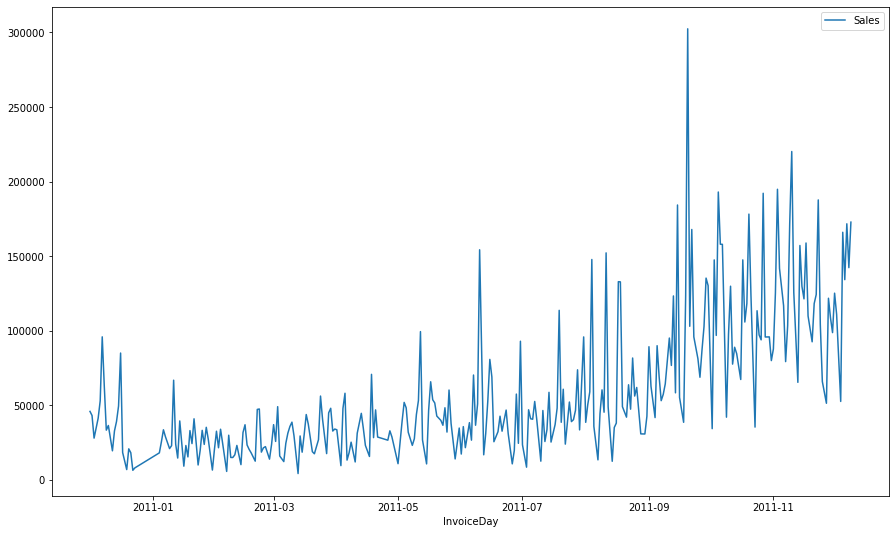

In [18]:
df_sales.groupby(['InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .plot(figsize=(15, 9));

There seems to be an upward trend, which is great. But let's try breaking things down more.
### Channels
First, let's confirm products can be sold via multiple channels:

In [3]:
print(f"SPACEBOY TV DINNER TRAY sold via: {df_sales[df_sales.SKU == '22474'].Channel.unique()}")

SPACEBOY TV DINNER TRAY sold via: ['Mailing' 'Store' 'Organic Social' 'SEO' 'Email']


Next, let's examine the sales amount per channel:

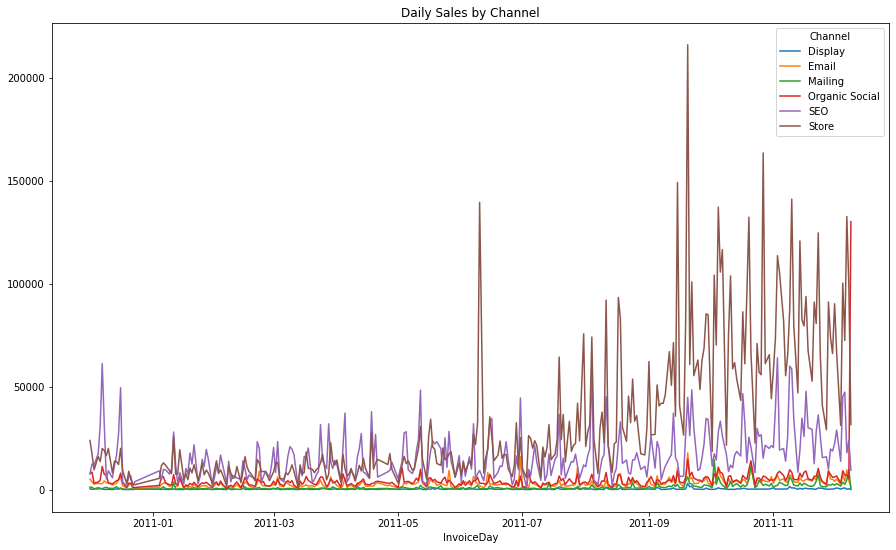

In [32]:
df_sales.groupby(['Channel', 'InvoiceDay'])\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel");

That's pretty noisy. But at a glance, it seems like Store sales have grown to become our largest sales channel, outpacing SEO by an increasingly large margin. There also seems to be a huge amount of variance in store sales, with some curious outliers. Stores and SEO account for the vast majority of sales, while other channels seem to have experienced more stagnant growth.

Let's try looking at a 10 day rolling average.

In [29]:
df_rolling = df_sales.groupby(['Channel', 'InvoiceDay'])\
                .agg({'Sales': 'sum'})\
                .rolling(10)\
                .mean()\
                .dropna()

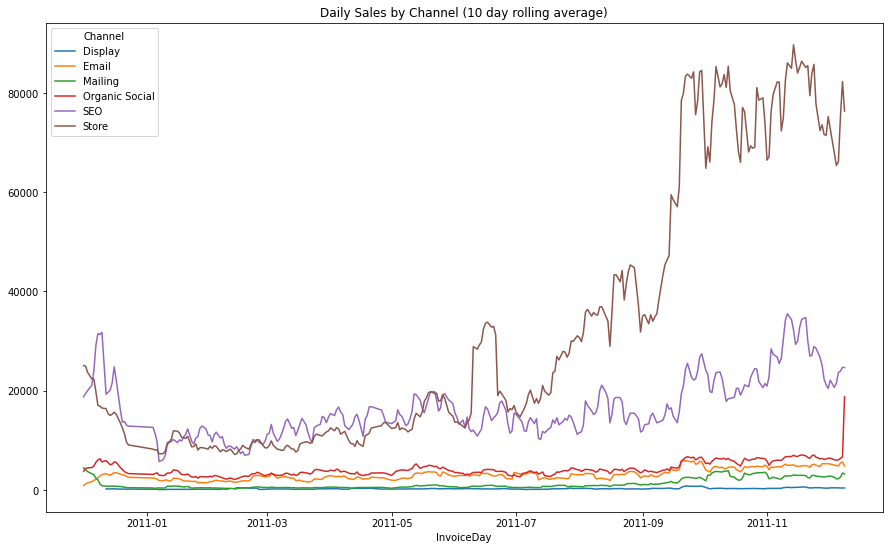

In [31]:
df_rolling.reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel (10 day rolling average)");

That's a lot cleaner, and it better illustrates the ascendance of store sales.